# Word Embeddings

In this notebook, you will implement 2 algorithms for learning word embeddings. You will use these algorithms to measure semantic similarity between words.

### Imports

In [ ]:
%matplotlib inline

## Standard Library
import random
from string import punctuation
from collections import Counter

## External Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
import gensim.downloader

# PyTorch Modules: see http://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
print("GPU Available:", torch.cuda.is_available())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
GPU Available: True


In [ ]:
## Simple Plotting Utility
def showPlot(title, *args):
    plt.figure()
    fig, ax = plt.subplots()
    for a in args:
      _ = ax.plot(a)
    _ = ax.set_title(title)

In [ ]:
def tokenize(text):
    """
    Simple tokenizer (sentences and then words)
    """
    sentences = sent_tokenize(text)
    examples = []
    for sentence in sentences:
        sentence = "".join(char for char in sentence if char not in punctuation)
        sentence = "".join(char for char in sentence if not char.isdigit())
        sentence = sentence.lower()
        tokens = word_tokenize(sentence)
        examples.append(tokens)
    return examples

tokenize("Why, hello there! What's your name?")

[['why', 'hello', 'there'], ['whats', 'your', 'name']]

### Data

We provide two datasets. Use the small dataset to develop your algorithms and test semantic similarity at the end of the notebook. Use the larger dataset once your models are developed to get a sense for the scalability of your approaches.

Please include visualizations of the train/test loss for both datasets. For the small dataset, please train your models for 1000 epochs. For the large dataset, please train your models for at least 100 epochs.

In [ ]:
# Text is lightly adapted (removing punctuation and possesives) from The Raven by Edgar Allan Poe
text_small = [""" Once upon a midnight dreary while I pondered weak and weary
 Over many a quaint and curious volume of forgotten lore
 While I nodded nearly napping suddenly there came a tapping
 As of some one gently rapping rapping at my chamber door
 This is some visiter I muttered tapping at my chamber door
                          Only this and nothing more

 Ah distinctly I remember it was in the bleak December
 And each separate dying ember wrought its ghost upon the floor
 Eagerly I wished the morrow vainly I had sought to borrow
 From my books surcease of sorrow sorrow for the lost Lenore
 For the rare and radiant maiden whom the angels name Lenore
                          Nameless here for evermore

 And the silken sad uncertain rustling of each purple curtain
 Thrilled me filled me with fantastic terrors never felt before
 So that now to still the beating of my heart I stood repeating
 This is some visiter entreating entrance at my chamber door
 Some late visiter entreating entrance at my chamber door
                          This it is and nothing more

 Presently my soul grew stronger hesitating then no longer
 Sir said I or Madam truly your forgiveness I implore
 But the fact is I was napping and so gently you came rapping
 And so faintly you came tapping tapping at my chamber door
 That I scarce was sure I heard you here I opened wide the door
                          Darkness there and nothing more

 Deep into that darkness peering long I stood there wondering fearing
 Doubting dreaming dreams no mortal ever dared to dream before
 But the silence was unbroken and the darkness gave no token
 And the only word there spoken was the whispered word Lenore
 This I whispered and an echo murmured back the word Lenore
                          Merely this and nothing more

 Back into the chamber turning all my soul within me burning
 Soon I heard again a tapping somewhat louder than before
 Surely said I surely that is something at my window lattice
 Let me see then what thereat is and this mystery explore
 Let my heart be still a moment and this mystery explore
                          This is the wind and nothing more

 Open here I flung the shutter when with many a flirt and flutter
 In there stepped a stately raven of the saintly days of yore
 Not the least obeisance made he not an instant stopped or stayed he
 But with mien of lord or lady perched above my chamber door
 Perched upon a bust of Pallas just above my chamber door
                          Perched and sat and nothing more

 Then this ebony bird beguiling my sad fancy into smiling
 By the grave and stern decorum of the countenance it wore
 Though thy crest be shorn and shaven thou I said art sure no craven
 Ghastly grim and ancient raven wandering from the Nightly shore
 Tell me what thy lordly name is on the Night Plutonian shore
                          Quoth the raven Nevermore

 Much I marvelled this ungainly fowl to hear discourse so plainly
 Though its answer little meaninglittle relevancy bore
 For we cannot help agreeing that no living human being
 Ever yet was blessed with seeing bird above his chamber door
 Bird or beast upon the sculptured bust above his chamber door
                         With such name as Nevermore

 But the raven sitting lonely on the placid bust spoke only
 That one word as if his soul in that one word he did outpour
 Nothing farther then he utterednot a feather then he fluttered
 Till I scarcely more than muttered Other friends have flown before
 On the morrow he will leave me as my hopes have flown before
                          Then the bird said Nevermore

 Startled at the stillness broken by reply so aptly spoken
 Doubtless said I what it utters is its only stock and store
 Caught from some unhappy master whom unmerciful Disaster
 Followed fast and followed faster till his songs one burden bore
 Till the dirges of his Hope that melancholy burden bore
                         Of Never nevermore

 But the raven still beguiling all my sad soul into smiling
 Straight I wheeled a cushioned seat in front of bird and bust and door
 Then upon the velvet sinking I betook myself to thinking
 Fancy unto fancy thinking what this ominous bird of yore
 What this grim ungainly ghastly gaunt and ominous bird of yore
                         Meant in croaking Nevermore

 This I sat engaged in guessing but no syllable expressing
 To the fowl whose fiery eyes now burned into my bosom core
 This and more I sat divining with my head at ease reclining
 On the cushion velvet lining that the lamplght gloated over
 But whose velvet violet lining with the lamplight gloating over
                          She shall press ah nevermore

 Then me thought the air grew denser perfumed from an unseen censer
 Swung by Angels whose faint foot-falls tinkled on the tufted floor
 Wretch I cried thy God hath lent theeby these angels he hath sent
 thee
 Respite respite and nepenthe from thy memories of Lenore
 Quaff oh quaff this kind nepenthe and forget this lost Lenore
                           Quoth the raven Nevermore

 Prophet said I thing of evil prophet still if bird or devil
 Whether Tempter sent or whether tempest tossed thee here ashore
 Desolate yet all undaunted on this desert land enchanted
 On this home by Horror haunted tell me truly I implore
 Is there is there balm in Gilead tell me tell me I implore
                           Quoth the raven Nevermore

 Prophet said I thing of evil prophet still if bird or devil
 By that Heaven that bends above us by that God we both adore
 Tell this soul with sorrow laden if within the distant Aidenn
 It shall clasp a sainted maiden whom the angels name Lenore
 Clasp a rare and radiant maiden whom the angels name Lenore
                           Quoth the raven Nevermore

 Be that word our sign of parting bird or fiend I shrieked upstarting
 Get thee back into the tempest and the Night Plutonian shore
 Leave no black plume as a token of that lie thy soul hath spoken
 Leave my loneliness unbroken quit the bust above my door
 Take thy beak from out my heart and take thy form from off my door
                          Quoth the raven Nevermore

 And the raven never flitting still is sitting still is sitting
 On the pallid bust of Pallas just above my chamber door
 And his eyes have all the seeming of a demon that is dreaming
 And the lamp-light over him streaming throws his shadow on the floor
 And my soul from out that shadow that lies floating on the floor
                          Shall be lifted nevermore"""]

In [ ]:
## Retrieve/Load Data
data = fetch_20newsgroups(subset="test", ## Choose Test Since Full Dataset Will Take Significant Training Time                         
                          remove=("headers","footers","quotes"),
                          data_home="./data/",
                          download_if_missing=True,
                          shuffle=False)

## Isolate Data
text_large = data.data
labels = data.target

## Show Sample Newsgroups Data
show = lambda i: print(text_large[i], "\n", tokenize(text_large[i]))
show(30)




It wasn't Jesus who changed the rules of the game (see quote above),
it was Paul.

Cheers,
Kent
 
 [['it', 'wasnt', 'jesus', 'who', 'changed', 'the', 'rules', 'of', 'the', 'game', 'see', 'quote', 'above', 'it', 'was', 'paul'], ['cheers', 'kent']]


In [ ]:
## Tokenize Data (We Recommend Developing your model using text_small first)
documents = list(map(tokenize, text_small))
# documents = list(map(tokenize, text_large))

## Flatten Sentences
documents = [tokens for d in documents for tokens in d]
print("Dataset Size:", len(documents))

Dataset Size: 1


In [ ]:
## Choose Frequency and Top Word Removal (Should Change This Depending on the Dataset)
MIN_FREQ = 0
RM_TOP = 0

## Get Vocabulary
vocab = [t for document in documents for t in document]
vocab_counts = Counter(vocab)
stopwords = set([s[0] for s in vocab_counts.most_common(RM_TOP)])
vocab = set([v for v in set(vocab) if vocab_counts[v] >= MIN_FREQ and v not in stopwords] + ["EOS"])
vocab_size = len(vocab)
print("Vocab Size:", vocab_size)

# Build a dictionary so that each word in vocabualary is assigned a number and 
# and we can map each number back to the word
w2i = {w: i for i, w in enumerate(sorted(vocab))}
i2w = {i: w for i, w in enumerate(sorted(vocab))}

Vocab Size: 435


In [ ]:
## Update The Documents with OOV Token
documents = [list(filter(lambda token: token in vocab, document)) for document in documents]

## Sample Training And Test Documents
np.random.seed(1)
documents_train = documents_test = documents
if len(documents) > 1:
    train_ind, test_ind = train_test_split(list(range(len(documents))))
    documents_train = [documents[t] for t in train_ind]
    documents_test = [documents[t] for t in test_ind]

![Continuous bag of words vs. skipgram model](https://raw.githubusercontent.com/jojonki/word2vec-pytorch/master/word2vec.PNG)

Image from https://github.com/jojonki/word2vec-pytorch

## CBOW Implementation

Fill in the TODOs below.

In [ ]:
## Choose Context Size
CONTEXT_SIZE = 2

# Tuple of an array of words (the context) to a word (the target)
def create_cbow_dataset(documents, context_size):
    data = []
    for document in documents:
        ## Pad the sentence
        document = ["EOS"] * context_size + document + ["EOS"] * context_size
        ## Get Context Tokens
        for i in range(context_size, len(document) - context_size):
            target = document[i]
            before_ctx = []
            after_ctx = []
            for j in range(1,context_size+1):
                before_ctx.append(document[i - j])
                after_ctx.append(document[i + j])
            context = before_ctx + after_ctx
            data.append((context, target))
    return data

## Generate Datasets
cbow_train = create_cbow_dataset(documents_train, context_size=CONTEXT_SIZE)
cbow_test = create_cbow_dataset(documents_test, context_size=CONTEXT_SIZE)

## Show Samples
print('cbow train samples')
for i in range(5):
    print(cbow_train[i])
print("total train samples", len(cbow_train))
print("total test samples", len(cbow_test))

cbow train samples
(['EOS', 'EOS', 'upon', 'a'], 'once')
(['once', 'EOS', 'a', 'midnight'], 'upon')
(['upon', 'once', 'midnight', 'dreary'], 'a')
(['a', 'upon', 'dreary', 'while'], 'midnight')
(['midnight', 'a', 'while', 'i'], 'dreary')
total train samples 1090
total test samples 1090


In [ ]:
## Example of the Dataset Generator
create_cbow_dataset([["hello","there","my","friend"]], 2)

[(['EOS', 'EOS', 'there', 'my'], 'hello'),
 (['hello', 'EOS', 'my', 'friend'], 'there'),
 (['there', 'hello', 'friend', 'EOS'], 'my'),
 (['my', 'there', 'EOS', 'EOS'], 'friend')]

In [ ]:
## Helper Function to Construct Batches of Examples
def get_cbow_batches(data, batch_size):
    """
    Generate batches of data for training CBOW Model
    """
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    current_batch = []
    for i, indice in enumerate(indices):
        context, target = data[indice]
        ctx_idxs = [w2i[w] for w in context]
        ctx_var = torch.LongTensor(ctx_idxs)
        current_batch.append((ctx_var, torch.LongTensor([w2i[target]])))
        if current_batch and len(current_batch) % batch_size == 0 or i == len(indices) - 1:
            batch_context = torch.stack([v[0] for v in current_batch])
            batch_target = torch.stack([v[1] for v in current_batch])
            current_batch = []
            yield batch_context, batch_target


In [ ]:
# Simple 3 layer network to map target word to an array of probabilities for 
# each word being in its context
# Note that the first layer is a special layer - an embedding layer 
# It maps the one-hot encoded vocabulary to a vector of a fixed size 
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        #TODO implement layers show in the picture above
        self.embedding = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2 * context_size * embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        self.activation = nn.LogSoftmax(dim = -1)
    
    def forward(self, inputs):
        #TODO implement the forward of CBOW architecture
        embedded = self.embedding(inputs)
        embedded = embedded.view(embedded.shape[0], -1)
        hidden = F.relu(self.linear1(embedded))
        out = self.linear2(hidden)
        output = self.activation(out)
        
        return output

In [ ]:
def train_cbow(train_data,
               test_data,
               model=None,
               n_epoch=1000,
               embd_size=100,
               learning_rate=0.01,
               context_size=CONTEXT_SIZE,
               batch_size=20,
               hidden_size=128,
               print_every=50,
               random_seed=1):
    """
    
    """
    ## Set Random Seed
    torch.manual_seed(random_seed)
    ## Batch size
    batch_size = min(batch_size, len(train_data))
    ## Initialize New Model if Not Using Existing
    if model is None:
        model = CBOW(vocab_size, embd_size, context_size, hidden_size)
    ## GPU
    gpu_avail = torch.cuda.is_available()
    if gpu_avail:
        model = model.cuda()
    ## Show the Model
    print(model)
    ## Initialize Optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    ##TODO: Choose the appropriate loss function
    loss_fn = nn.NLLLoss()
    ## Cache for Loss Values
    losses = []
    test_losses = []
    ## Training Loop
    for epoch in range(n_epoch):
        total_loss = .0
        model.train()
        for batch, (context, target) in enumerate(get_cbow_batches(train_data, batch_size)):
            ##TODO implement training procedure for CBOW
            context = context.cuda()
            target = target.cuda()
            outputs = model(context)
            loss = loss_fn(outputs,target.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            total_loss += loss.item()
            
            if print_every is not None and (batch + 1) % print_every == 0:
                print("Epoch {} || batch {} || Loss: {:.4f}".format(epoch+1, batch+1, total_loss / (batch+1)))
        
        model.eval()
        ##TODO Compute Loss on Test and Training Data
        train_loss = total_loss / (batch+1)
        test_loss = 0
        for batch1, (context_t, target_t) in enumerate(get_cbow_batches(test_data, batch_size)):
            context_t = context_t.cuda()
            target_t = target_t.cuda()
            outputs_t = model(context_t)
            loss_t = loss_fn(outputs_t,target_t.squeeze())
            test_loss += loss_t.item()
        test_loss = test_loss / (batch1+1)
        print("Epoch {}/{} || Train Loss: {:.4f} || Test Loss: {:.4f}".format(epoch+1, n_epoch, train_loss, test_loss))
        losses.append(train_loss)
        test_losses.append(test_loss)
    print("Training Complete.")
    return model, losses, test_losses

## Train Model
cbow_model, cbow_losses, cbow_test_losses = train_cbow(cbow_train,
                                     cbow_test,
                                     model=None,
                                     n_epoch=1000,
                                     embd_size=100,
                                     context_size=CONTEXT_SIZE,
                                     batch_size=20,
                                     learning_rate=0.01,
                                     hidden_size=128,
                                     print_every=50)



CBOW(
  (embedding): Embedding(435, 100)
  (linear1): Linear(in_features=400, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=435, bias=True)
  (activation): LogSoftmax(dim=-1)
)
Epoch 1 || batch 50 || Loss: 6.1055
Epoch 1/1000 || Train Loss: 6.1065 || Test Loss: 6.0410
Epoch 2 || batch 50 || Loss: 6.0267
Epoch 2/1000 || Train Loss: 6.0199 || Test Loss: 5.9582
Epoch 3 || batch 50 || Loss: 5.9430
Epoch 3/1000 || Train Loss: 5.9399 || Test Loss: 5.8752
Epoch 4 || batch 50 || Loss: 5.8559
Epoch 4/1000 || Train Loss: 5.8562 || Test Loss: 5.7907
Epoch 5 || batch 50 || Loss: 5.7709
Epoch 5/1000 || Train Loss: 5.7693 || Test Loss: 5.7019
Epoch 6 || batch 50 || Loss: 5.6822
Epoch 6/1000 || Train Loss: 5.6808 || Test Loss: 5.6070
Epoch 7 || batch 50 || Loss: 5.5902
Epoch 7/1000 || Train Loss: 5.5866 || Test Loss: 5.5130
Epoch 8 || batch 50 || Loss: 5.4902
Epoch 8/1000 || Train Loss: 5.4831 || Test Loss: 5.4110
Epoch 9 || batch 50 || Loss: 5.3834
Epoch 9/1000 || Tr

In [ ]:
## Test Predictive Accuracy
def test_cbow(test_data, model, sample_size=None, seed=42, use_gpu=False):
    ## Random State
    np.random.seed(seed)
    ## Count Correct Answers
    correct_ct = 0
    ## Downsample if Desired (To Save Time)
    if sample_size is None:
        sample = test_data
    else:
        sample = np.random.choice(len(test_data), sample_size, replace=False)
        sample = [test_data[s] for s in sample]
    ## Evaluate
    model.eval()
    for ctx_var, target in get_cbow_batches(sample, 1):
        if use_gpu:
            ctx_var = ctx_var.cuda()
        model.zero_grad()
        log_probs = model(ctx_var)
        if use_gpu:
            log_probs = log_probs.cpu()
        #_, predicted = torch.max(log_probs[0], 1)
        predicted = torch.argmax(log_probs[0])
        if torch.eq(predicted, target[0]):
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(sample)*100, correct_ct, len(sample)))

test_cbow(cbow_train, cbow_model, sample_size=min(5000, len(cbow_train)), use_gpu=torch.cuda.is_available())
test_cbow(cbow_test, cbow_model, sample_size=min(5000, len(cbow_test)), use_gpu=torch.cuda.is_available())

Accuracy: 99.8% (1088/1090)
Accuracy: 99.8% (1088/1090)


<Figure size 432x288 with 0 Axes>

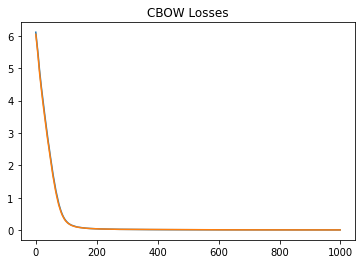

In [ ]:
showPlot('CBOW Losses',cbow_losses,cbow_test_losses)

## Skip-gram Implementation

We've now trained an embedding using the continuous bag of words model. Below, we also show code for training the opposite model - the skipgram model - where you predict the context words based on a target word.

Note how simple the SkipGram network is. There are no linear layers - just the embedding layer, and the training simply aims to maximize the dot product of embeddings of the target and embedding words.

#### Dataset Generation

We provide the beginning of a function for generating the skipgram dataset. You need to implement negative sampling.

In [ ]:
# Tuple of a word (the target) to a word (a context word)
def create_skipgram_dataset(documents, context_size, k_negative=5):
    data = []
    for document in documents:
        document = ["EOS"] * context_size + document + ["EOS"] * context_size
        for i in range(context_size, len(document) - context_size):
            word_set = set()
            for j in range(1, context_size+1):
                data.append((document[i], document[i-j], 1))
                data.append((document[i], document[i+j], 1))

            ##TODO: Implement negative sampling
            for _ in range(k_negative):
                rand_id = random.randint(0, vocab_size-1)
                if not rand_id in word_set:
                    data.append((document[i], i2w[rand_id], 0))
    return data

## Create Datasets
skipgram_train = create_skipgram_dataset(documents_train, context_size=CONTEXT_SIZE, k_negative=5)
skipgram_test = create_skipgram_dataset(documents_test, context_size=CONTEXT_SIZE, k_negative=5)

## Show Samples
print('skipgram sample', skipgram_train[:10])

skipgram sample [('once', 'EOS', 1), ('once', 'upon', 1), ('once', 'EOS', 1), ('once', 'a', 1), ('once', 'then', 0), ('once', 'name', 0), ('once', 'heaven', 0), ('once', 'distinctly', 0), ('once', 'lattice', 0), ('upon', 'once', 1)]


In [ ]:
## Create Batches
def get_sgram_batches(data, batch_size):
    """

    """
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    current_batch = []
    for i, indice in enumerate(indices):
        in_w, out_w, target = data[indice]
        in_w_var = torch.LongTensor([w2i[in_w]])
        out_w_var = torch.LongTensor([w2i[out_w]])
        target_t = torch.Tensor([target])
        current_batch.append((in_w_var, out_w_var, target_t))
        if current_batch and len(current_batch) % batch_size == 0 or i == len(indices) - 1:
            batch_in_w_var = torch.stack([v[0] for v in current_batch])
            batch_out_w_var = torch.stack([v[1] for v in current_batch])
            batch_target = torch.stack([v[2] for v in current_batch])
            current_batch = []
            yield batch_in_w_var, batch_out_w_var, batch_target


In [ ]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        #TODO implement layers shown in the picture above
        self.embedding = nn.Embedding(vocab_size, embd_size)

    def forward(self, focus, context):
        #TODO implement forward of SkipGram.
        embed_f = self.embedding(focus)
        embed_c = self.embedding(context)
        score = torch.mul(embed_f, embed_c).squeeze(1).sum(dim=1)
        probs = torch.sigmoid(score)
        return probs

In [ ]:
def train_skipgram(train_data,
                   test_data,
                   model=None,
                   n_epoch=1000,
                   learning_rate=0.01,
                   batch_size=30,
                   embd_size=128,
                   print_every_step=None,
                   print_every_epoch=50,
                   random_seed=1):
    """
    
    """
    ## Set Random Seed
    torch.manual_seed(random_seed)
    ## Initialize Model
    if model is None:
        model = SkipGram(vocab_size, embd_size)
    ## Put on GPU
    if torch.cuda.is_available():
        model = model.cuda()
    ## Show Model
    print(model)
    ## Initialize Optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    ##TODO: Choose the appropriate Loss Function
    loss_fn = nn.BCELoss()
    ## Loss Cache
    losses = []
    test_losses = []
    ## Training Loop
    for epoch in range(n_epoch):
        total_loss = .0
        for step, (in_w_var, out_w_var, target_t) in enumerate(get_sgram_batches(train_data, batch_size)):
            #TODO implement training procedure for SkipGram
            in_w_var = in_w_var.cuda()
            out_w_var = out_w_var.cuda()
            target_t = target_t.cuda()

            model.zero_grad()
            probs = model(in_w_var, out_w_var)
            loss = loss_fn(probs, target_t.squeeze())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
            if print_every_step is not None and (step + 1) % print_every_step == 0:
                print("Epoch {} || Step {}/{} || Loss: {:.4f}".format(epoch+1, step+1, len(train_data), (total_loss / step+1)))
            
        if print_every_epoch is not None and (epoch + 1) % print_every_epoch == 0:
            print("Epoch {}/{} || Loss: {:.4f}".format(epoch+1, n_epoch, total_loss / (step+1)))
        model.eval()
        ##TODO Compute Losses
        train_loss = total_loss / (step+1)
        test_loss = 0
        for step1, (in_w_var1, out_w_var1, target_t1) in enumerate(get_sgram_batches(test_data, batch_size)):
            #TODO implement training procedure for SkipGram
            in_w_var1 = in_w_var1.cuda()
            out_w_var1 = out_w_var1.cuda()
            target_t1 = target_t1.cuda()

            probs1 = model(in_w_var1, out_w_var1)
            loss_t = loss_fn(probs1, target_t1.squeeze())
            test_loss += loss_t.item()
        test_loss = test_loss / (step1+1)
        losses.append(train_loss)
        test_losses.append(test_loss)
    print("Training Complete")
    return model, losses, test_losses

## Fit Model
sg_model, sg_losses, sg_tloss = train_skipgram(skipgram_train,
                                     skipgram_test,
                                     n_epoch=1000,
                                     learning_rate=0.01,
                                     batch_size=30,
                                     embd_size=128,
                                     print_every_step=None,
                                     print_every_epoch=50)

SkipGram(
  (embedding): Embedding(435, 128)
)
Epoch 50/1000 || Loss: 5.0520
Epoch 100/1000 || Loss: 3.9579
Epoch 150/1000 || Loss: 3.5199
Epoch 200/1000 || Loss: 3.3003
Epoch 250/1000 || Loss: 3.1846
Epoch 300/1000 || Loss: 3.1356
Epoch 350/1000 || Loss: 3.1175
Epoch 400/1000 || Loss: 3.1063
Epoch 450/1000 || Loss: 3.0816
Epoch 500/1000 || Loss: 3.0762
Epoch 550/1000 || Loss: 3.0632
Epoch 600/1000 || Loss: 3.0427
Epoch 650/1000 || Loss: 3.0396
Epoch 700/1000 || Loss: 3.0284
Epoch 750/1000 || Loss: 3.0173
Epoch 800/1000 || Loss: 2.9893
Epoch 850/1000 || Loss: 2.9866
Epoch 900/1000 || Loss: 2.9670
Epoch 950/1000 || Loss: 2.9645
Epoch 1000/1000 || Loss: 2.9627
Training Complete


<Figure size 432x288 with 0 Axes>

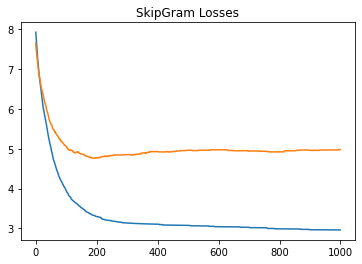

In [ ]:
## Plot Losses
showPlot('SkipGram Losses', sg_losses, sg_tloss)

In [ ]:
## Evaluate Accuracy
def test_skipgram(test_data, model):
    correct_ct = 0
    for in_w_var, out_w_var, target_t in get_sgram_batches(test_data, 1):

        if torch.cuda.is_available():
            in_w_var = in_w_var.cuda()
            out_w_var = out_w_var.cuda()
            target_t = target_t.cuda()
        probs = model(in_w_var, out_w_var)
        predicted = (probs > 0.5)
        correct_ct += torch.sum(torch.eq(predicted[0], target_t))

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

test_skipgram(skipgram_train, sg_model)
test_skipgram(skipgram_test, sg_model)

Accuracy: 93.5% (9173/9810)
Accuracy: 72.7% (7133/9810)


### Semantic Similarity
You are asked to write 2 functions. The first function `get_similarity` takes two terms in the vocabulary as arguments and returns their semantic similarity (cosine similarity). The second function `show_similar_terms` takes as an argument a term in the vocabulary and shows the top_k most similar terms based on cosine similarity. Use your functions to evaluate similarity of words in the Raven (based on your trained model) and some general words in the pretrained corpus.

*Note:* Typically, word embeddings are typically trained on much larger datasets than the ones we provide. You will not necessarily see interpretable similarities below. We are primarily interested in your implementation. Accordingly, we provide code that loads pretrained word embeddings learned using 27 billion tweets. Learn more here: https://nlp.stanford.edu/projects/glove/

In [ ]:
## Load Pretrained Vectors
glove_vectors = gensim.downloader.load('glove-twitter-25')

## Extract Embeddings and Vocab
glove_vocab = glove_vectors.index2word ## Note: If this doesn't work because of version < 4.0, use .index_to_key
glove_w2i = {w : i for i, w in enumerate(glove_vocab)}
glove_i2w = {i : w for i, w in enumerate(glove_vocab)}

## Convert Embeddings
glove_embeddings = nn.Embedding(len(glove_vocab), 25)
glove_embeddings = glove_embeddings.from_pretrained(torch.Tensor(glove_vectors.vectors))

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
def get_similarity(embeddings,
                   w2i,
                   term1,
                   term2):
    """

    """
    ## Check Terms
    for term in [term1, term2]:
        if term not in w2i:
            raise KeyError(f"Term `{term}` not found")
    ## Get Indices
    embeddings = embeddings.cpu()
    term1_ind = torch.LongTensor([w2i[term1]])
    term2_ind = torch.LongTensor([w2i[term2]])

  
    ##TODO: Retrieve Embeddings and Compute Cosine Similarity
    term1_embed, term2_embed = embeddings(term1_ind), embeddings(term2_ind)

    distance = float(cosine_distances(term1_embed.detach(), term2_embed.detach()))
    print(term1, term2, distance)

def show_similar_terms(embeddings, 
                       w2i,
                       i2w,
                       target_term,
                       top_k=10):
    """
    
    """
    ## Get Target Vector
    if target_term not in w2i:
        raise KeyError(f"Term `{target_term}` not in vocabulary")
    target_ind = torch.LongTensor([w2i[target_term]])
    ##TODO: Retrieve Embeddings for Target Term and Full Vocabulary
    ## Print out the top_k most similar terms based on cosine similarity
    embedding = embeddings(target_ind)
    cos_dis = np.array([cosine_distances(embeddings.weight[i,:].unsqueeze(dim=0).detach(), embedding.detach()) for i in range(embeddings.weight.shape[0])])
    cos_dis = cos_dis.flatten()
    top_terms = [i2w[i] for i in cos_dis.argsort()[1:top_k+1]]
    print(top_terms)

#### Evaluation

First, evaluate similarity for embeddings trained using The Raven snippet. Then evaluate similarity in the pretrained embeddings.

In [ ]:
## Evaluation for The Raven embeddings
get_similarity(cbow_model.embedding, w2i, "raven","nevermore")
get_similarity(cbow_model.embedding, w2i, "raven", "door")
show_similar_terms(cbow_model.embedding, w2i, i2w, "raven")

## Evaluation for The Raven Skipgram embeddings
get_similarity(sg_model.embedding, w2i, "raven","nevermore")
get_similarity(sg_model.embedding, w2i, "raven", "door")
show_similar_terms(sg_model.embedding, w2i, i2w, "raven")

raven nevermore 0.9213746190071106
raven door 1.0904384851455688
['stillness', 'ghastly', 'respite', 'prophet', 'merely', 'decorum', 'shrieked', 'moment', 'wretch', 'stronger']
raven nevermore 0.9367460012435913
raven door 1.0082436800003052
['wished', 'forgiveness', 'faintly', 'rare', 'doubtless', 'our', 'at', 'feather', 'bust', 'front']


In [ ]:
## Evaluation for Glove Embeddings
get_similarity(glove_embeddings, glove_w2i, "mouse","computer")
get_similarity(glove_embeddings, glove_w2i, "mouse","cat")
get_similarity(glove_embeddings, glove_w2i, "mouse","dog")
get_similarity(glove_embeddings, glove_w2i, "cat","dog")
show_similar_terms(glove_embeddings, glove_w2i, glove_i2w, "cat")

mouse computer 0.304571270942688
mouse cat 0.16189134120941162
mouse dog 0.23936331272125244
cat dog 0.04091787338256836
['dog', 'monkey', 'bear', 'pet', 'girl', 'horse', 'kitty', 'puppy', 'hot', 'lady']


##Evaluate large dataset

In [ ]:
## Tokenize Data (We Recommend Developing your model using text_small first)
documents = list(map(tokenize, text_large))
# documents = list(map(tokenize, text_large))

## Flatten Sentences
documents = [tokens for d in documents for tokens in d]
print("Dataset Size:", len(documents))

Dataset Size: 80164


In [ ]:
## Choose Frequency and Top Word Removal (Should Change This Depending on the Dataset)
MIN_FREQ = 0
RM_TOP = 0

## Get Vocabulary
vocab = [t for document in documents for t in document]
vocab_counts = Counter(vocab)
stopwords = set([s[0] for s in vocab_counts.most_common(RM_TOP)])
vocab = set([v for v in set(vocab) if vocab_counts[v] >= MIN_FREQ and v not in stopwords] + ["EOS"])
vocab_size = len(vocab)
print("Vocab Size:", vocab_size)

# Build a dictionary so that each word in vocabualary is assigned a number and 
# and we can map each number back to the word
w2i = {w: i for i, w in enumerate(sorted(vocab))}
i2w = {i: w for i, w in enumerate(sorted(vocab))}

Vocab Size: 65170


In [ ]:
## Update The Documents with OOV Token
documents = [list(filter(lambda token: token in vocab, document)) for document in documents]

## Sample Training And Test Documents
np.random.seed(1)
documents_train = documents_test = documents
if len(documents) > 1:
    train_ind, test_ind = train_test_split(list(range(len(documents))))
    documents_train = [documents[t] for t in train_ind]
    documents_test = [documents[t] for t in test_ind]

###CBOW

In [ ]:
## Choose Context Size
CONTEXT_SIZE = 2

# Tuple of an array of words (the context) to a word (the target)
def create_cbow_dataset(documents, context_size):
    data = []
    for document in documents:
        ## Pad the sentence
        document = ["EOS"] * context_size + document + ["EOS"] * context_size
        ## Get Context Tokens
        for i in range(context_size, len(document) - context_size):
            target = document[i]
            before_ctx = []
            after_ctx = []
            for j in range(1,context_size+1):
                before_ctx.append(document[i - j])
                after_ctx.append(document[i + j])
            context = before_ctx + after_ctx
            data.append((context, target))
    return data

## Generate Datasets
cbow_train = create_cbow_dataset(documents_train, context_size=CONTEXT_SIZE)
cbow_test = create_cbow_dataset(documents_test, context_size=CONTEXT_SIZE)

## Show Samples
print('cbow train samples')
for i in range(5):
    print(cbow_train[i])
print("total train samples", len(cbow_train))
print("total test samples", len(cbow_test))

cbow train samples
(['EOS', 'EOS', 'liberals', 'tend'], 'the')
(['the', 'EOS', 'tend', 'to'], 'liberals')
(['liberals', 'the', 'to', 'keep'], 'tend')
(['tend', 'liberals', 'keep', 'to'], 'to')
(['to', 'tend', 'to', 'themselves'], 'keep')
total train samples 944039
total test samples 314123


In [ ]:
def train_cbow(train_data,
               test_data,
               model=None,
               n_epoch=100,
               embd_size=100,
               learning_rate=0.01,
               context_size=CONTEXT_SIZE,
               batch_size=50,
               hidden_size=128,
               print_every=None,
               random_seed=1):
    """
    
    """
    ## Set Random Seed
    torch.manual_seed(random_seed)
    ## Batch size
    batch_size = min(batch_size, len(train_data))
    ## Initialize New Model if Not Using Existing
    if model is None:
        model = CBOW(vocab_size, embd_size, context_size, hidden_size)
    ## GPU
    gpu_avail = torch.cuda.is_available()
    if gpu_avail:
        model = model.cuda()
    ## Show the Model
    print(model)
    ## Initialize Optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    ##TODO: Choose the appropriate loss function
    loss_fn = nn.NLLLoss()
    ## Cache for Loss Values
    losses = []
    test_losses = []
    ## Training Loop
    for epoch in range(n_epoch):
        total_loss = .0
        model.train()
        for batch, (context, target) in enumerate(get_cbow_batches(train_data, batch_size)):
            ##TODO implement training procedure for CBOW
            context = context.cuda()
            target = target.cuda()
            outputs = model(context)
            loss = loss_fn(outputs,target.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            total_loss += loss.item()
            
            if print_every is not None and (batch + 1) % print_every == 0:
                print("Epoch {} || batch {} || Loss: {:.4f}".format(epoch+1, batch+1, total_loss / (batch+1)))
        
        model.eval()
        ##TODO Compute Loss on Test and Training Data
        train_loss = total_loss / (batch+1)
        test_loss = 0
        for batch_t, (context_t, target_t) in enumerate(get_cbow_batches(test_data, batch_size)):
            context_t = context_t.cuda()
            target_t = target_t.cuda()
            outputs_t = model(context_t)
            loss_t = loss_fn(outputs_t,target_t.squeeze())
            test_loss += loss_t.item()
        test_loss = test_loss / (batch_t+1)
        print("Epoch {}/{} || Train Loss: {:.4f} || Test Loss: {:.4f}".format(epoch+1, n_epoch, train_loss, test_loss))
        losses.append(train_loss)
        test_losses.append(test_loss)
    print("Training Complete.")
    return model, losses, test_losses

## Train Model
cbow_model, cbow_losses, cbow_test_losses = train_cbow(cbow_train,
                                     cbow_test,
                                     model=None,
                                     n_epoch=100,
                                     embd_size=100,
                                     context_size=CONTEXT_SIZE,
                                     batch_size=50,
                                     learning_rate=0.01,
                                     hidden_size=128,
                                     print_every=None)


CBOW(
  (embedding): Embedding(65170, 100)
  (linear1): Linear(in_features=400, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=65170, bias=True)
  (activation): LogSoftmax(dim=-1)
)
Epoch 1/100 || Train Loss: 8.0343 || Test Loss: 7.2390
Epoch 2/100 || Train Loss: 7.0282 || Test Loss: 6.8852
Epoch 3/100 || Train Loss: 6.7647 || Test Loss: 6.7197
Epoch 4/100 || Train Loss: 6.6104 || Test Loss: 6.6168
Epoch 5/100 || Train Loss: 6.5005 || Test Loss: 6.5448
Epoch 6/100 || Train Loss: 6.4138 || Test Loss: 6.4919
Epoch 7/100 || Train Loss: 6.3418 || Test Loss: 6.4446
Epoch 8/100 || Train Loss: 6.2788 || Test Loss: 6.4109
Epoch 9/100 || Train Loss: 6.2227 || Test Loss: 6.3809
Epoch 10/100 || Train Loss: 6.1715 || Test Loss: 6.3558
Epoch 11/100 || Train Loss: 6.1245 || Test Loss: 6.3322
Epoch 12/100 || Train Loss: 6.0800 || Test Loss: 6.3135
Epoch 13/100 || Train Loss: 6.0383 || Test Loss: 6.2967
Epoch 14/100 || Train Loss: 5.9981 || Test Loss: 6.2818
Epoch 15/10

In [ ]:
def train_cbow(train_data,
               test_data,
               model=None,
               n_epoch=100,
               embd_size=100,
               learning_rate=0.01,
               context_size=CONTEXT_SIZE,
               batch_size=50,
               hidden_size=128,
               print_every=None,
               random_seed=1):
    """
    
    """
    ## Set Random Seed
    torch.manual_seed(random_seed)
    ## Batch size
    batch_size = min(batch_size, len(train_data))
    ## Initialize New Model if Not Using Existing
    if model is None:
        model = CBOW(vocab_size, embd_size, context_size, hidden_size)
    ## GPU
    gpu_avail = torch.cuda.is_available()
    if gpu_avail:
        model = model.cuda()
    ## Show the Model
    print(model)
    ## Initialize Optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    ##TODO: Choose the appropriate loss function
    loss_fn = nn.NLLLoss()
    ## Cache for Loss Values
    losses = []
    test_losses = []
    ## Training Loop
    for epoch in range(n_epoch):
        total_loss = .0
        model.train()
        for batch, (context, target) in enumerate(get_cbow_batches(train_data, batch_size)):
            ##TODO implement training procedure for CBOW
            context = context.cuda()
            target = target.cuda()
            outputs = model(context)
            loss = loss_fn(outputs,target.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            total_loss += loss.item()
            
            if print_every is not None and (batch + 1) % print_every == 0:
                print("Epoch {} || batch {} || Loss: {:.4f}".format(epoch+1, batch+1, total_loss / (batch+1)))
        
        model.eval()
        ##TODO Compute Loss on Test and Training Data
        train_loss = total_loss / (batch+1)
        test_loss = 0
        for batch_t, (context_t, target_t) in enumerate(get_cbow_batches(test_data, batch_size)):
            context_t = context_t.cuda()
            target_t = target_t.cuda()
            outputs_t = model(context_t)
            loss_t = loss_fn(outputs_t,target_t.squeeze())
            test_loss += loss_t.item()
        test_loss = test_loss / (batch_t+1)
        print("Epoch {}/{} || Train Loss: {:.4f} || Test Loss: {:.4f}".format(epoch+1, n_epoch, train_loss, test_loss))
        losses.append(train_loss)
        test_losses.append(test_loss)
    print("Training Complete.")
    return model, losses, test_losses

## Train Model
cbow_model, cbow_losses, cbow_test_losses = train_cbow(cbow_train,
                                     cbow_test,
                                     model=None,
                                     n_epoch=100,
                                     embd_size=100,
                                     context_size=CONTEXT_SIZE,
                                     batch_size=50,
                                     learning_rate=0.01,
                                     hidden_size=128,
                                     print_every=None)

CBOW(
  (embedding): Embedding(65170, 100)
  (linear1): Linear(in_features=400, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=65170, bias=True)
  (activation): LogSoftmax(dim=-1)
)
Epoch 1/100 || Train Loss: 8.0328 || Test Loss: 7.2378
Epoch 2/100 || Train Loss: 7.0281 || Test Loss: 6.8853
Epoch 3/100 || Train Loss: 6.7644 || Test Loss: 6.7211
Epoch 4/100 || Train Loss: 6.6104 || Test Loss: 6.6177
Epoch 5/100 || Train Loss: 6.5002 || Test Loss: 6.5457
Epoch 6/100 || Train Loss: 6.4136 || Test Loss: 6.4891
Epoch 7/100 || Train Loss: 6.3416 || Test Loss: 6.4474
Epoch 8/100 || Train Loss: 6.2789 || Test Loss: 6.4093
Epoch 9/100 || Train Loss: 6.2226 || Test Loss: 6.3814
Epoch 10/100 || Train Loss: 6.1718 || Test Loss: 6.3533
Epoch 11/100 || Train Loss: 6.1241 || Test Loss: 6.3325
Epoch 12/100 || Train Loss: 6.0798 || Test Loss: 6.3134
Epoch 13/100 || Train Loss: 6.0377 || Test Loss: 6.2962
Epoch 14/100 || Train Loss: 5.9974 || Test Loss: 6.2821
Epoch 15/10

In [ ]:
## Test Predictive Accuracy
def test_cbow(test_data, model, sample_size=None, seed=42, use_gpu=False):
    ## Random State
    np.random.seed(seed)
    ## Count Correct Answers
    correct_ct = 0
    ## Downsample if Desired (To Save Time)
    if sample_size is None:
        sample = test_data
    else:
        sample = np.random.choice(len(test_data), sample_size, replace=False)
        sample = [test_data[s] for s in sample]
    ## Evaluate
    model.eval()
    for ctx_var, target in get_cbow_batches(sample, 1):
        if use_gpu:
            ctx_var = ctx_var.cuda()
        model.zero_grad()
        log_probs = model(ctx_var)
        if use_gpu:
            log_probs = log_probs.cpu()
        #_, predicted = torch.max(log_probs[0], 1)
        predicted = torch.argmax(log_probs[0])
        if torch.eq(predicted, target[0]):
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(sample)*100, correct_ct, len(sample)))

test_cbow(cbow_train, cbow_model, sample_size=min(5000, len(cbow_train)), use_gpu=torch.cuda.is_available())
test_cbow(cbow_test, cbow_model, sample_size=min(5000, len(cbow_test)), use_gpu=torch.cuda.is_available())

Accuracy: 28.6% (1428/5000)
Accuracy: 18.6% (930/5000)


<Figure size 432x288 with 0 Axes>

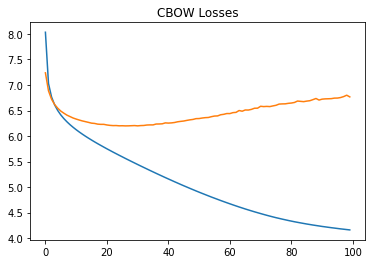

In [ ]:
showPlot('CBOW Losses',cbow_losses,cbow_test_losses)

In [ ]:
#save the model
PATH = "gdrive/MyDrive/'cbow_model_large.pt'"
torch.save(cbow_model, PATH)
#load
#the_model = torch.load(PATH)

###skip-gram

In [ ]:
# Tuple of a word (the target) to a word (a context word)
CONTEXT_SIZE = 2
def create_skipgram_dataset(documents, context_size, k_negative=5):
    data = []
    for document in documents:
        document = ["EOS"] * context_size + document + ["EOS"] * context_size
        for i in range(context_size, len(document) - context_size):
            word_set = set()
            for j in range(1, context_size+1):
                data.append((document[i], document[i-j], 1))
                data.append((document[i], document[i+j], 1))

            ##TODO: Implement negative sampling
            for _ in range(k_negative):
                rand_id = random.randint(0, vocab_size-1)
                if not rand_id in word_set:
                    data.append((document[i], i2w[rand_id], 0))
    return data

## Create Datasets
skipgram_train = create_skipgram_dataset(documents_train, context_size=CONTEXT_SIZE, k_negative=5)
skipgram_test = create_skipgram_dataset(documents_test, context_size=CONTEXT_SIZE, k_negative=5)

## Show Samples
print('skipgram sample', skipgram_train[:10])

skipgram sample [('the', 'EOS', 1), ('the', 'liberals', 1), ('the', 'EOS', 1), ('the', 'tend', 1), ('the', 'fencesitters', 0), ('the', 'ramses', 0), ('the', 'namibia', 0), ('the', 'sweeps', 0), ('the', 'hazirliklari', 0), ('liberals', 'the', 1)]


In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [ ]:
def train_skipgram(train_data,
                   test_data,
                   model=None,
                   n_epoch=100,
                   learning_rate=0.01,
                   batch_size=100,
                   embd_size=128,
                   print_every_step=None,
                   print_every_epoch=1,
                   random_seed=1):
    """
    
    """
    ## Set Random Seed
    torch.manual_seed(random_seed)
    ## Initialize Model
    if model is None:
        model = SkipGram(vocab_size, embd_size)
    ## Put on GPU
    if torch.cuda.is_available():
        model = model.cuda()
    ## Show Model
    print(model)
    ## Initialize Optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    ##TODO: Choose the appropriate Loss Function
    loss_fn = nn.BCELoss()
    ## Loss Cache
    losses = []
    test_losses = []
    ## Training Loop
    for epoch in range(n_epoch):
        total_loss = .0
        for step, (in_w_var, out_w_var, target_t) in enumerate(get_sgram_batches(train_data, batch_size)):
            #TODO implement training procedure for SkipGram
            in_w_var = in_w_var.cuda()
            out_w_var = out_w_var.cuda()
            target_t = target_t.cuda()

            model.zero_grad()
            probs = model(in_w_var, out_w_var)
            loss = loss_fn(probs, target_t.squeeze())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
            if print_every_step is not None and (step + 1) % print_every_step == 0:
                print("Epoch {} || Step {}/{} || Loss: {:.4f}".format(epoch+1, step+1, len(train_data), (total_loss / step+1)))
            
        if print_every_epoch is not None and (epoch + 1) % print_every_epoch == 0:
            print("Epoch {}/{} || Loss: {:.4f}".format(epoch+1, n_epoch, total_loss / step+1))
        model.eval()
        ##TODO Compute Losses
        train_loss = total_loss / (step+1)
        test_loss = 0
        for step_t, (in_w_var1, out_w_var1, target_t1) in enumerate(get_sgram_batches(test_data, batch_size)):
            #TODO implement training procedure for SkipGram
            in_w_var1 = in_w_var1.cuda()
            out_w_var1 = out_w_var1.cuda()
            target_t1 = target_t1.cuda()

            probs1 = model(in_w_var1, out_w_var1)
            loss_t = loss_fn(probs1, target_t1.squeeze())
            test_loss += loss_t.item()
        test_loss = test_loss / (step_t+1)
        losses.append(train_loss)
        test_losses.append(test_loss)
    print("Training Complete")
    return model, losses, test_losses

## Fit Model
sg_model, sg_losses, sg_tloss = train_skipgram(skipgram_train,
                                     skipgram_test,
                                     n_epoch=100,
                                     learning_rate=0.01,
                                     batch_size=100,
                                     embd_size=128,
                                     print_every_step=None,
                                     print_every_epoch=1)

SkipGram(
  (embedding): Embedding(65170, 128)
)
Epoch 1/100 || Loss: 7.2432
Epoch 2/100 || Loss: 6.1211
Epoch 3/100 || Loss: 5.7049
Epoch 4/100 || Loss: 5.4461
Epoch 5/100 || Loss: 5.2564
Epoch 6/100 || Loss: 5.1082
Epoch 7/100 || Loss: 4.9859
Epoch 8/100 || Loss: 4.8829
Epoch 9/100 || Loss: 4.7948
Epoch 10/100 || Loss: 4.7155
Epoch 11/100 || Loss: 4.6446
Epoch 12/100 || Loss: 4.5808
Epoch 13/100 || Loss: 4.5226
Epoch 14/100 || Loss: 4.4686
Epoch 15/100 || Loss: 4.4194
Epoch 16/100 || Loss: 4.3721
Epoch 17/100 || Loss: 4.3293
Epoch 18/100 || Loss: 4.2875
Epoch 19/100 || Loss: 4.2485
Epoch 20/100 || Loss: 4.2111
Epoch 21/100 || Loss: 4.1753
Epoch 22/100 || Loss: 4.1415
Epoch 23/100 || Loss: 4.1090
Epoch 24/100 || Loss: 4.0776
Epoch 25/100 || Loss: 4.0472
Epoch 26/100 || Loss: 4.0185
Epoch 27/100 || Loss: 3.9906
Epoch 28/100 || Loss: 3.9629
Epoch 29/100 || Loss: 3.9367
Epoch 30/100 || Loss: 3.9108
Epoch 31/100 || Loss: 3.8855
Epoch 32/100 || Loss: 3.8612
Epoch 33/100 || Loss: 3.8382
Epo

<Figure size 432x288 with 0 Axes>

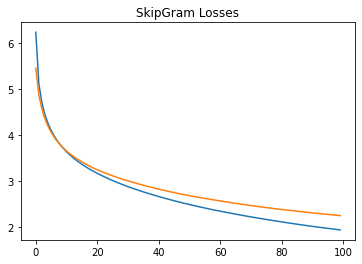

In [ ]:
## Plot Losses
showPlot('SkipGram Losses', sg_losses,sg_tloss)

In [ ]:
## Evaluate Accuracy
def test_skipgram(test_data, model):
    correct_ct = 0
    for in_w_var, out_w_var, target_t in get_sgram_batches(test_data, 1000):

        if torch.cuda.is_available():
            in_w_var = in_w_var.cuda()
            out_w_var = out_w_var.cuda()
            target_t = target_t.cuda()
        probs = model(in_w_var, out_w_var)
        predicted = (probs > 0.5)
        correct_ct += torch.sum(torch.eq(predicted[0], target_t))

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

test_skipgram(skipgram_train, sg_model)
test_skipgram(skipgram_test, sg_model)

Accuracy: 48.6% (4131093/8496351)
Accuracy: 48.4% (1368728/2827107)


In [ ]:
#save the model
PATH = "gdrive/MyDrive/'sg_model_large.pt'"
torch.save(sg_model, PATH)
#load
#the_model = torch.load(PATH)

###Evaluate Semantic Similarity for the large dataset

In [ ]:
#Load model
PATH1 = "gdrive/MyDrive/'sg_model_large.pt'"
PATH2 = "gdrive/MyDrive/'cbow_model_large.pt'"
sg_large_model = torch.load(PATH1,map_location=torch.device('cpu'))
cbow_large_model = torch.load(PATH2,map_location=torch.device('cpu'))

In [ ]:
## Evaluation for The large dataset embeddings
get_similarity(cbow_large_model.embedding, w2i, "friendship","racer")
show_similar_terms(cbow_large_model.embedding, w2i, i2w, "friendship")

## Evaluation for The large dataset embeddings
get_similarity(sg_large_model.embedding, w2i, "friendship","racer")
show_similar_terms(sg_large_model.embedding, w2i, i2w, "friendship")

friendship racer 1.1169114112854004
['maybee', 'opel', 'rival', 'unix', 'cccp', 'kiribati', 'chlamydomonas', 'sakic', 'colora', 'mmaxqbcbfuxdzlp']
friendship racer 1.0530095100402832
['slvruc', 'evy', 'zheleznovodsk', 'kisio', 'lawshminpit', 'prepackaged', 'darkhorse', 'slaughter', 'polymorphonuclear', 'facelift']
